In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-08-23 08:47:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 209.85.145.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   266MB/s    in 0.6s    

2023-08-23 08:47:47 (266 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# unzipe data
import zipfile

zip_ref = zipfile.ZipFile(file="/content/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
for root, dirs, files in os.walk("/content/10_food_classes_10_percent"):
  if files:
    for file in files:
      print(os.path.join(root, file))


In [ ]:
for root, dirs, files in os.walk("/content/10_food_classes_10_percent"):

  if len(root.split("/")) > 3 and root.split("/")[3] == "test" :
    print(root)

In [21]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [23]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [24]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# These URLs link to a saved pretrained model on TensorFlow Hub.
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


# create model
def create_model(model_url, num_classes = 10):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable= False, # freeze the underlying patterns
                                           name= 'feature_extraction_layer',
                                           input_shape= IMAGE_SHAPE)

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])
  return model



# compile
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# train

history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230823-085226
Epoch 1/5
24/24 [==============================] - 28s 609ms/step - loss: 1.8880 - accuracy: 0.3493 - val_loss: 1.1620 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - 12s 506ms/step - loss: 0.9228 - accuracy: 0.7480 - val_loss: 0.8124 - val_accuracy: 0.7636
Epoch 3/5
24/24 [==============================] - 12s 501ms/step - loss: 0.6420 - accuracy: 0.8400 - val_loss: 0.7080 - val_accuracy: 0.7880
Epoch 4/5
24/24 [==============================] - 12s 509ms/step - loss: 0.4938 - accuracy: 0.8680 - val_loss: 0.6464 - val_accuracy: 0.8048
Epoch 5/5
24/24 [==============================] - 12s 500ms/step - loss: 0.3976 - accuracy: 0.9133 - val_loss: 0.6131 - val_accuracy: 0.8184


In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
# Plot the validation and training data separately

import matplotlib.pyplot as plt

def plot_curves(history, epochs):
  loss = history.history['loss']
  accuracy = history.history['accuracy']

  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  epochs = range(epochs)

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

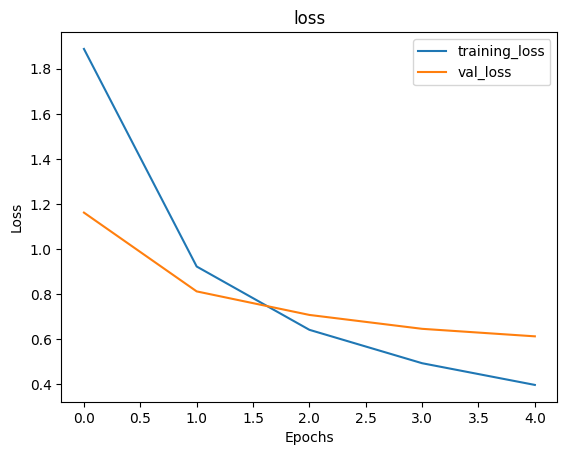

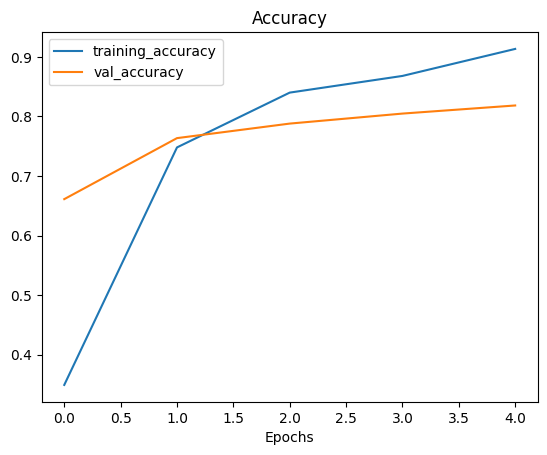

In [39]:
plot_curves(history, epochs=5)

In [40]:
# EfficientNetB0 model

# Create model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230823-091932
Epoch 1/5
24/24 [==============================] - 26s 583ms/step - loss: 1.8219 - accuracy: 0.4560 - val_loss: 1.2808 - val_accuracy: 0.7516
Epoch 2/5
24/24 [==============================] - 11s 476ms/step - loss: 1.0517 - accuracy: 0.7600 - val_loss: 0.8592 - val_accuracy: 0.8204
Epoch 3/5
24/24 [==============================] - 11s 463ms/step - loss: 0.7510 - accuracy: 0.8413 - val_loss: 0.6907 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 11s 459ms/step - loss: 0.6032 - accuracy: 0.8813 - val_loss: 0.5990 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.5162 - accuracy: 0.8907 - val_loss: 0.5468 - val_accuracy: 0.8676


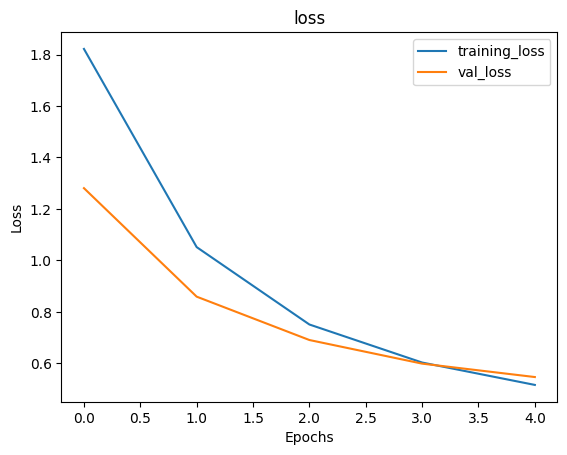

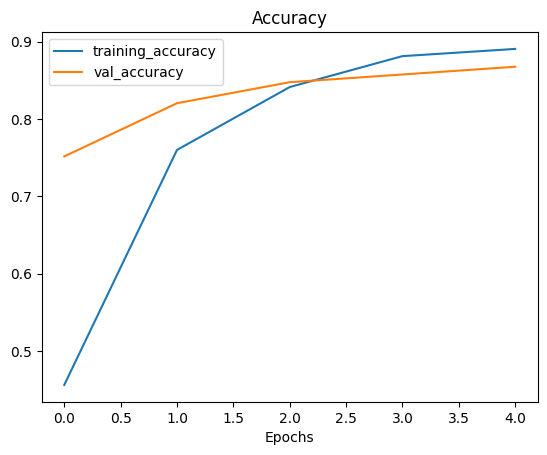

In [41]:
plot_curves(efficientnet_history, epochs = 5)

In [42]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [43]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-08-23 09:30:24.306184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   KZZD-CXJK



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

In [44]:
# Check out experiments
!tensorboard dev list

2023-08-23 09:34:48.266388: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/gwhAW0ljTdq96qCyw5XvHw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   gwhAW0ljTdq96qCyw5XvHw
	Created              2023-08-23 09:31:38 (3 minutes ago)
	Updated              2023-08-23 09:31:40 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5813502
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]